In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (7,4)

Simulation de systèmes dynamiques non lisses
==============================


Le cours se focalise sur l'étude de systèmes dynamiques réguliers, c'est-à-dire $\dot{x}=f(x)$ avec $f$ au moins continue, et le plus souvent continûment différentiable. Le but de ce projet est de découvrir des systèmes moins réguliers, dits *non-lisses*. Il existe une myriade de modélisations de ces systèmes mais on peut distinguer différents *niveaux* d'irrégularité:

 - $f$ est continue mais non différentiable en certains points (on parle de *nonsmooth dynamics of type 1*, i.e., *NSD1*) : cela peut arriver dans la modélisation d'écoulements par exemple. Dans ce cas, les solutions $t\mapsto x(t)$ restent $C^1$ mais leur simulation peut déjà se compliquer.

 - $f$ est discontinue en certains points, ou le long de certaines surfaces (on parle de *NSD2*) : ceci apparaît typiquement en mécanique lors de la modélisation de contacts et friction entre solides, ou dans la modélisation de circuits électriques contenant des diodes par exemple. Dans ce cas, les solutions $t\mapsto x(t)$ sont toujours (absolument) continues mais non différentiables, le schéma numérique doit détecter des changements de *mode*.

 - les solutions $t\mapsto x(t)$ sont elles-mêmes discontinues, présentant des *sauts*  à certains instants ou lorsqu'elles rencontrent certaines surfaces, et il faut ajouter à $f$ un modèle de ces sauts (on parle de *NSD3*) : ceci apparaît typiquement avec les systèmes mécaniques à impact.

L'étude mathématique de ces sytèmes est très complexe, faisant appel à des outils qui nous mèneraient trop loin de ce cours (inclusions différentielles, complémentarité, analyse convexe, *measure differential inclusions*, etc), notre but est seulement d'en découvrir certains aspects à travers des exemples iconiques. Les curieux peuvent se référer à la documentation fournie par 

https://www.inria.fr/en/modelling-mechanics-simulation-fibres

https://www.inria.fr/en/tripop

ou aux ouvrages de références tels que

https://link.springer.com/book/10.1007/978-94-015-7793-9

https://link.springer.com/book/10.1007/978-3-540-44398-8 




## Dynamique non différentiable (NSD1)

Reprenons la loi de Toriccelli étudiée en TD et modélisant (modulo reparamétrisation) l'écoulement d'un fluide dans un réservoir
$$
\dot{x} = - \sqrt{|x|} \tag{1}
$$

**Question 1** Coder un schéma Euler explicite permettant de simuler une équation différentielle $\dot{x}=f(x,t)$ à partir d'une condition initiale $x_0$ au temps $t_0$ jusqu'au temps $t_f$ avec un pas de temps $dt$. 

Schema d'Euler $x_{n+1}=x_n + \delta(t)f(t_n, x_n)$

In [17]:
def euler_explicit(f,x0,t0,tf,dt):
    time = np.arange(t0, tf+dt, dt) # on crée le vecteur temps avec t0 temps initial, tf temps final et dt intervalle de temps
    time[0]=t0
    N = len(time)
    sol = np.zeros(N) # on fait une liste de 0 pour la solution, cas x appartient à R peut etre faire si un vecteur...
    sol[0] = x0 #on initialise 
    for i in range (0, N-1):
        sol[i+1] = sol[i] + dt*f(time[i],sol[i]) #schema d'euler
    
    return time, sol



In [6]:
#on veut tester sur Toriccelli 
def f_torricceli(t,x): 
    return -np.sqrt(np.abs(x))



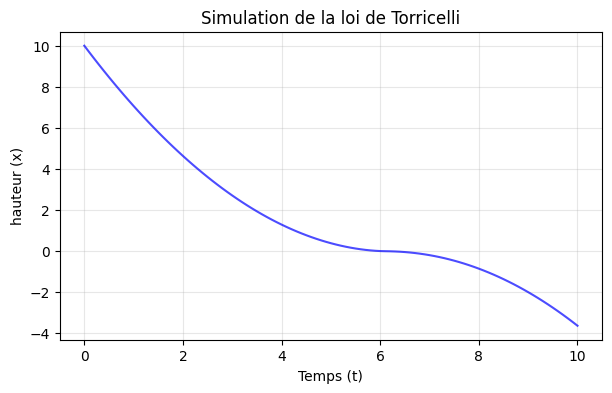

In [33]:
x0=10
t0=0
tf=10
dt=0.1
t, x = euler_explicit(f_torricceli, x0, t0, tf, dt)
# on veut tracer maintenant
plt.plot(t, x, label=f"Euler Explicite (dt={dt})", color='blue', alpha=0.7)
plt.title("Simulation de la loi de Torricelli")
plt.xlabel("Temps (t)")
plt.ylabel("hauteur (x)")
plt.grid(True, alpha=0.3)
plt.show()

**Question 2** L'utiliser pour simuler un écoulement d'une hauteur initiale $x_0=10$ pendant 10 unités de temps. Tracer la solution obtenue. Est-elle celle que l'on attend ? Les solver ''odeint'' ou ''solve_ivp" de scipy fait-il mieux ? Expliquer pourquoi. Proposer une façon de simuler *la* solution *physique*.



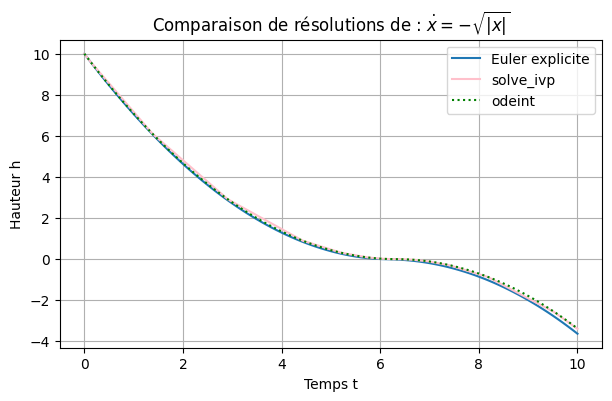

In [39]:
def f_bis(x,t): 
    return -np.sqrt(np.abs(x))
#Le methode odeint prend en arguement une fonction f(x,t) alors que EUler et solve_ip s'appliquent a une fonction f(t,x)
x0=10
t0=0
tf=10
dt=0.1

t, x = euler_explicit(f_torricceli, x0, t0, tf, dt)
sol_odeint = odeint(f_bis, x0, t)
sol_ivp = solve_ivp(f_torricceli, [t0, tf], [x0])

plt.plot(t, x, label="Euler explicite", linestyle='-')
plt.plot(sol_ivp.t, sol_ivp.y[0], label="solve_ivp", linestyle='-', color='pink')
plt.plot(t, sol_odeint, label="odeint", linestyle=':', color="green")
#La methode solv_ip chosi automatiquement un pas de temps adapté



plt.title(r"Comparaison de résolutions de : $\dot{x} = -\sqrt{|x|}$")
plt.xlabel("Temps t")
plt.ylabel("Hauteur h")
plt.legend()
plt.grid(True)
plt.show()


__Réponse 2:__
On modélise la hauteur de l'eau, celle-ci décroit progressivement (très rapidement au début puis la pente diminue ce qui est logique car moins il y a d'eau dans la colonne plus le débit diminue) dans les deux cas on atteint une hauteur nulle autour de t=6. Mais la solution x(t) n'est pas physique car la hauteur ne reste pas constante égale à 0 mais passe dans les valeurs négatives.
Aucun des solveurs n'est à proprement parler meilleur car le problème réside ici en la non differentiabilité en $x=0$ pour regler ce problème et obtenir une solution "physique" on pourrait redefinir l'équation  differentielle en: $$\dot{x} = - \sqrt{max(0,x)}$$
On a alors que $0$ est un équilibre du système.




En pratique, on essaye toujours de se ramener à une modélisation *bien posée* dont les solutions existent et sont uniques (ajout de contraintes ou régularisation, par exemple). Ici, on pourrait par exemple considérer plutôt
$$
\dot{x} = - {\rm sign}(x) \sqrt{|x|} \tag{2}
$$
avec ${\rm sign}(0)$ arbitraire. 

**Question 3** Montrer que pour toute condition initiale dans $\mathbb{R}$, (2) admet une unique solution maximale en temps positif définie sur $\mathbb{R}_{\geq 0}$, et qu'elle correspond à la solution ``physique'' attendue précédemment pour des conditions initiales positives. Justifier que l'on parle de "convergence globale vers 0 en temps fini". Illustrer ce phénomène en simulation. Ce comportement serait-il possible pour $\dot{x}=f(x)$ avec $f$ continûment différentiable ?


__Réponse 3:__

La fonction qui à $$f: (t,x) \mapsto & - {\rm sign}(x(t)) \sqrt{|x(t)|}$$ est continue sur $\mathbb{R} \times \mathbb{R}$ donc le théorème de Peano assure l’existence de solutions au problème de Cauchy dans $\mathbb{R}$ pour toute condition initiale.

De plus $- {\rm sign}(x) \sqrt{|x|} <= 1+|x|$, pour tout $x \in \mathbb{R}$ donc f est bornée de manière affine et toute solution maximale est définie sur $\mathbb{R}$.  
Enfin, f est continuement différentiable sur $\mathbb{R} \times (\mathbb{R} \backslash \lbrace{0}\rbrace)$ donc quand $x_0 \neq 0 $, il existe une unique solution maximale dans $\mathbb{R} \backslash \lbrace{0}\rbrace $ d'après le théorème de Cauchy-Lipschitz.  
Donc, la solution est unique tant qu'elle ne passe pas par $0$.

On peut aussi résoudre cette équation differentielle par séparation des variables, en integrant entre $t_0=0$ et t, on obtient que pour une solution initiale $x_0>0$ et tant que $t<2\sqrt{x_0}$.  
$$x(t)=({-1/2}(2\sqrt{x_0}-t))^{1/2}$$ 
On parle de convergence en temps fini vers $0$ car pour $t=2\sqrt{x_0}$, on a : $x(t)=0$. On prolonge cette solution par continuité par $x(t)=0$ pour tout $t>2\sqrt{x_0}$. <br>
On prouve l'unicité en raisonnant par l'absurde. On suppose qu'il existe $T>2\sqrt{x_0}$ telle que  $x(T)!=0$, on suppose sans perte de généralité que $x(T)>0$.  Par continuité, il existe un intervalle du type $]T, T+ \delta_t[$ où $x$ est strictement positive. En injectant dans l'equation différentielle on a $\dot{x}(t)= - \sqrt{x} <0$ sur cet intervalle et donc que la solution est strictement décroissante. Or la fonction part de 0 et est décroissant donc il n'existera pas de temps pour laquelle elle est strictement positive. La solution est unique.

Cela correspond bien a une solution dite "physique". En effet, si la hauteur du reservoir atteint $0$ elle y reste et il n'y a plus d'écoulement.

Si $f$ est $C^1$ on peut appliquer le théorème de Cauchy-Lipschitz qui nous dit qu'il existe une unique solution maximale. Si le système admet un équilibre,c'est à dire s'il existe $a$ tel que $f(a)=0$ alors la solution constante égale à $a$ est une solution maximale. On considère $f$ tel que $$f\in C^1(\mathbb{R}), \ f(0)=0$$
On raisonne par l'absurde en supposant qu'il existe une solution partant de $x_0$ non nul qui atteigne $0$: $$\exists \ T \in \mathbb{R}, \ x(T)=0 $$ or $x_{eq}(T)=0$ et par Cauchy-Lipschitz on sait qu'il y a une unique solution donc $x(t)$ est la fonction constante nulle. Cela est absurde car $x_0 >0$.  
Cette dynamique n'est donc pas possible pour $f $ continuement différentiable. 


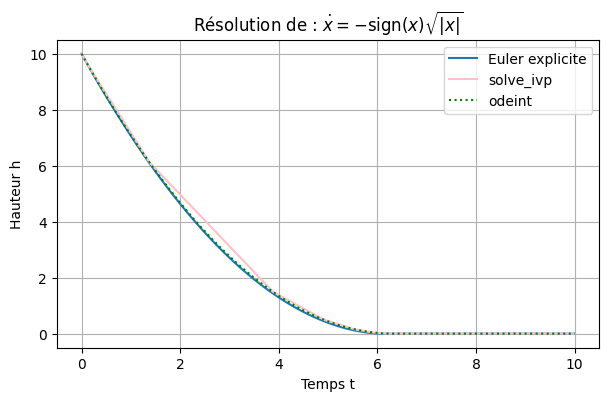

In [40]:
def f1(t,x):
    return -np.sign(x)*np.sqrt(np.abs(x))
def f1_bis(x,t): 
    return -np.sign(x)*np.sqrt(np.abs(x))
#Le methode odeint prend en arguement une fonction f(x,t) alors que EUler et solve_ip s'appliquent a une fonction f(t,x)
x0=10
t0=0
tf=10
dt=0.1

t, x = euler_explicit(f1, x0, t0, tf, dt)
sol_odeint = odeint(f1_bis, x0, t,mxstep=3000)
#on évite l'erreur " Excess work done" en mettant un nombre  d'itérations maximal
sol_ivp = solve_ivp(f1, [t0, tf], [x0])

plt.plot(t, x, label="Euler explicite", linestyle='-')
plt.plot(sol_ivp.t, sol_ivp.y[0], label="solve_ivp", linestyle='-', color='pink')
plt.plot(t, sol_odeint, label="odeint", linestyle=':', color="green")
#La methode solv_ip chosi automatiquement un pas de temps adapté



plt.title(r"Résolution de : $\dot{x} = -\mathrm{sign}(x)\sqrt{|x|}$")
plt.xlabel("Temps t")
plt.ylabel("Hauteur h")
plt.legend()
plt.grid(True)
plt.show()


## Dynamique discontinue (NSD2)



Passons maintenant à une irrégularité plus forte, lorsque la fonction $f$ décrivant l'équation différentielle $\dot{x}=f(x)$ est discontinue, c'est-à-dire lorsque la solution $x$ suit des dynamiques différentes selon les régions de l'espace (par exemple selon le sens du courant pour des diodes, selon le sens de la vitesse pour des frottements secs etc.). Un exemple emblématique de ce cas de figure est 
$$
\dot{x} = - k {\rm sign}(x) \tag{3}
$$
pour $k>0$ et la valeur de ${\rm sign}(0)$ à définir. Dans ce contexte, on affaiblie la régularité des solutions recherchées, qui ne sont plus nécessairement $C^1$ sur leur intervalle de définition. Par contre, elles sont toujours censées vérifier l'équation intégrale 
$$
x(t) = x(t_0) + \int_{t_0}^t f(s,x(s)) ds
$$
et on considère donc la classe des solutions *absolument continues*, qui vérifient l'équation différentielle *pour presque tout $t$* seulement. 

**Question 4** Démontrer que pour une valeur de ${\rm sign}(0)$ bien choisie, (3) admet, pour toute condition initiale $x_0\in \mathbb{R}$, une unique solution maximale $t\mapsto x(t)$ en temps positif définie sur $\mathbb{R}_{\geq 0}$ et convergeant en temps fini vers 0. L'expliciter.



__Réponse 4__ On souhaite garde une solution physique au problème $(3)$ donc $0$ doit être un équilibre du système ce qui nous impose $sign(0)=0$.  
La fonction $f=-ksign(x)$ est discontinue, on peut regarder son comportement sur l'ouvert $]0, +\infty[$:  
On considère une valeur initiale $x_0 >0$ et $x$ est alors strictement positif sur un intervalle. En effet, comme x0>0 on a que $\dot{x}=-k<0$, donc x est décroissante. Si x<0 alors x serait passé par 0 (d'après le TVI) or cela est absurde car si x croise 0 il y reste. Cela nous permet de réécrire $f=-k$ qui est constante ( donc $C^1$ et l'existence sur cet ouvert est garantie par le théorème de Cauchy-Lipschitz) et de résoudre $(3)$.  
On obtient $x(t)=x_0 -kt$ pour $t < t_f =\frac{x_0}{k}$.  
On prolonge la solution par la fonction nulle pour $t\geq t_f$. La solution $x$ obtenue qui vérifie bien l'équation intégrale $(7)$.  
La solution est symétrique si on considère $x_0<0$. La convergence vers $0$ se fait bien en temps fini. On peut expliciter $T_f = \frac{|x_0|}{k}$ et la solution en temps positif:
$$x(t) = \text{sign}(x_0) \max(0, |x_0| - kt)$$

 

Considérons maintenant $\delta_m>0$ et l'équation différentielle perturbée
$$
\dot{x} = - k{\rm sign}(x) + \delta(t) \tag{4}
$$
pour $t\mapsto \delta(t)$ telle que $|\delta(t)|\leq \delta_m$ pour tout $t$.

**Question 5** Démontrer que si $k>\delta_m$, alors (4) admet toujours, pour toute condition initiale $x_0\in \mathbb{R}^*$ et quelle que soit la perturbation $\delta$ bornée par $\delta_m$, une unique solution maximale $t\mapsto x(t)$ en temps positif et convergeant en temps fini vers 0. Justifier que ces solutions pourraient être définie sur $\mathbb{R}_{\geq 0}$ si on acceptait que ${\rm sign}(0)$ puisse prendre n'importe quelle valeur entre -1 et 1.




__Réponse 5__  
Tant que $x\neq0$, la fonction $-ksgn(x)$ est localement constante par rapport à $x$ et f est alors localement lipschitzienne par rapport à $x$. Et on sait que pour $x_0>0$, il existe un intervalle où $x>0$. Par Cauchy-Lipschitz, l'existence et l'unicité locale sont donc assurés pour $x_0 \in \mathbb{R}^*$.  
On suppose $x_0>0$, tant que la solution est strictement positive ($sign(x)=1$) on a : $$\dot{x} = - k + \delta(t)$$
Comme $|\delta(t)|\leq \delta_m$ on a:
$$\dot{x} \leq -k + \delta_m$$
On sait que $k>\delta_m$ donc $-k + \delta_m<0$, donc en notant $\lambda= k - \delta_m$ on a $$  \dot{x}\leq -\lambda, \lambda>0  $$
Par intégration :$$x(t) = x_0 + \int_{0}^t \dot{x}(s) ds \leq x_0 - \lambda t$$
Comme $\dot{x}<0$ on sait que la fonction $x(t)$ est strictement décroissante, par l'inegalité précedent on observe que la solution atteint nécessairement $0$ en un temps fini $T$:
$$\exists T \text{ tel que } x(T) = 0, \quad T \leq \frac{x_0}{k - \delta_m}$$
Le raisonnement est symétrique pour $x_0 < 0$ avec $\dot{x}(t) \geq \lambda > 0$. 




Pour conclure, pour tout $\delta_m$ tel que $k> \delta_m$ et pour toute solution initiale $x_0 \in \mathbb{R}^*$, il existe une unique solution maximale qui converge en temps fini vers 0. 

On charche à appliquer un raisonnement similaire a la question 3 et 4 et ainsi prolonger la solution par 0 et montrer son unicité par l'absurde. On regarde l'existence d'une solution définie sur $\mathbb{R}_{\geq 0}$. Pour qu'une solution puisse rester à l'état $x(t) = 0$ sur un intervalle de temps, sa dérivée doit être nulle pour presque tout $t$. En injectant dans l'equation $(4)$ cela revient à la condition:
$$ 0=-ksign(0) +\delta(t)$$ qui se traduit comme condition sur $sign(0):$
$$ |sgn(0)|=\frac{|\delta(t)|}{k}<\frac{\delta_m}{k} $$ 
On a bien $|sign(0)|<1$ et on voit que si on accepte que $sign(0)$ prennent une valeur _glissante_ dans cette intervalle $]-1,1[$ alors pour n'importe quelle perturbation $\delta(t)<\delta_m$ il sera possible d'avoir un équilibre en $0$.



Ceci mène en fait à la notion d'*inclusion différentielle* $\dot{x}\in f(x)$, où la fonction signe serait ici une fonction *multivaluée*, c'est-à-dire à valeurs ensembliste (*set-valued map*), définie par
$$
{\rm Sign}(x) = \left\{
\begin{array}{ll}
{1} & \text{si x>0} \\
[-1,1] & \text{si x=0} \\
-1 & \text{si x<0}
\end{array}
\right.
$$
Ce genre de phénomène est utilisé en commande ou estimation par *mode-glissant* (*sliding mode*) pour stabiliser des systèmes dynamiques en temps fini et malgré la présence de perturbations inconnues ou d'incertitudes dans le modèle. Le prix à payer pour ce genre de système est une grande sensibilité au bruit et une difficulté accrue de les discrétiser et simuler.

*Pour la culture* : La théorie des inclusions différentielles a été développée par Filippov, voir https://link.springer.com/book/10.1007/978-3-319-28664-8. Elle a montré que le ``bon'' cadre pour qu'une inclusion différentielle ait de bonnes propriétés (notamment que des approximations de solutions convergent vers des solutions, c'est-à-dire la compacité séquentielle des solutions, permettant la discrétisation et simulation de ces systèmes) est lorsque $f$ est semi-continue supérieure, localement bornée et à valeurs convexes et fermées. D'où l'intervalle $[-1,1]$ pour ${\rm sign}(0)$ qui est le plus petit convexe fermé assurant la semi-continuité supérieure de ${\rm sign}$. 


**Question 6** Illustrer numériquement la convergence en temps finie globale et la robustesse aux perturbations de (4) à l'aide du schéma numérique de votre choix.

On veut illustrer la convergence donc montrer que x(t) part de $x_0$ et s'écrase sur l'axe des abscisses rapidement (temps fini T). Pour la robustesse, il s'agit de montrer que même si on ajoute une perturbation $\delta (t)$, le système atteint quand même 0 en un temps fini.  
Nous allons réaliser un schéma Runge-Kutta d'ordre 4 à pas fixe.

In [36]:
def RK4(f, x0, t0, tf, dt): 
    time = np.arange(t0, tf+dt, dt) # on crée le vecteur temps avec t0 temps initial, tf temps final et dt intervalle de temps
    time[0]=t0
    N = len(time)
    sol = np.zeros(N) # on fait une liste de 0 pour la solution, cas x appartient à R peut etre faire si un vecteur...
    sol[0] = x0 #on initialise 
    for j in range (N-1):
        F1 = f(time[j],sol[j])
        F2 = f(time[j]+(dt/2), sol[j]+(dt/2)*F1)
        F3 = f(time[j]+(dt/2), sol[j]+(dt/2)*F2)
        F4 = f(time[j]+dt, sol[j]+dt*F3)
        sol[j+1] = sol[j]+dt*(F1+2*F2+2*F3+F4)/6
    return time,sol

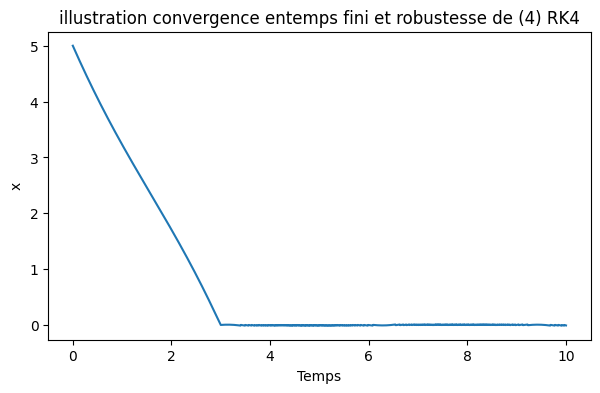

In [37]:
#avant de definir la fonction f on doit definir la perturbation delta t 
#on donne un gain k
k = 2
def delta(t):
    return 0.5*np.sin(t)
def f_perturbation(t,x): 
    return -k * np.sign(x) +delta(t)

t,x = RK4(f_perturbation, x0=5, t0=0, tf=10, dt=0.01)

plt.plot(t,x)
plt.title('illustration convergence entemps fini et robustesse de (4) RK4')
plt.xlabel('Temps')
plt.ylabel('x')
plt.show()

On voit très clairement une decroissance rapide vers 0. La solution semble atteindre 0 vers t=3. 

**Question 7** Illustrer et commenter le comportement du schéma d'Euler explicite autour de 0. On parle de phénomène de chattering. Que se passe-t-il si $k$ est grand ? Proposer un schema d'Euler implicite pour ce système et montrer qu'il permet d'éviter ce *chattering* et d'assurer une convergence numérique exacte vers 0.


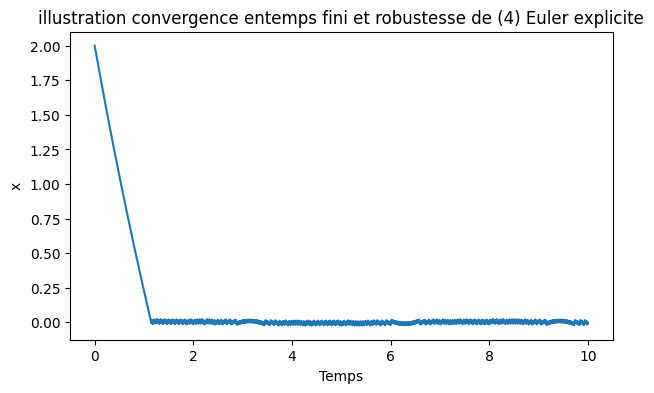

In [38]:
#on réutilise la fonction euler_explicite définie plus haut 
temps, solution = euler_explicit(f_perturbation, x0=2, t0=0, tf=10, dt=0.01)
plt.plot(temps,solution)
plt.title('illustration convergence entemps fini et robustesse de (4) Euler explicite')
plt.xlabel('Temps')
plt.ylabel('x')
plt.show()

Si on prend $x_0$ proche de 0 on a une décroisance casi immediate vers 0 et des toutes petites oscillations (de l'ordre de $x_0 / 10$).  On remarque que si $ ∣xn∣$ est plus petit que $dt*k$, donc si $x_0$ l'est, le système saute en de l'autre coté de zéro à chaque itération.
Maintenant si k est grand, pareil on voit des oscillations très régulieres autour de 0 (un petit peu bizarre). L'amplitude des oscillations augmentent avec k. On a l'impression que l'amplitude de ce chattering est proportionnelle à $k*dt$. Il semblerait que plus on veut avoir un $k$ grand (corriger vite), plus il y a des isntabilités autour de zéro. 


In [39]:
def euler_implicit_sliding(k, delta_func,x0,t0,tf,dt):
    time = np.arange(t0, tf+dt, dt) # on crée le vecteur temps avec t0 temps initial, tf temps final et dt intervalle de temps
    time[0]=t0
    N = len(t)
    sol = np.zeros(N) # on fait une liste de 0 pour la solution, cas x appartient à R peut etre faire si un vecteur...
    sol[0] = x0 #on initialise
    for j in range (N-1):
        # 1. On prédit la valeur sans la commande discontinue
        x_pred = sol[j] + dt * delta_func(time[j+1])
        
        # 2. Logique implicite pour le signe (Projection)
        if abs(x_pred) <= dt * k:
            sol[j+1] = 0  # Convergence exacte vers 0 !
        else:
            sol[j+1] = x_pred - dt * k * np.sign(x_pred)
    return time, sol


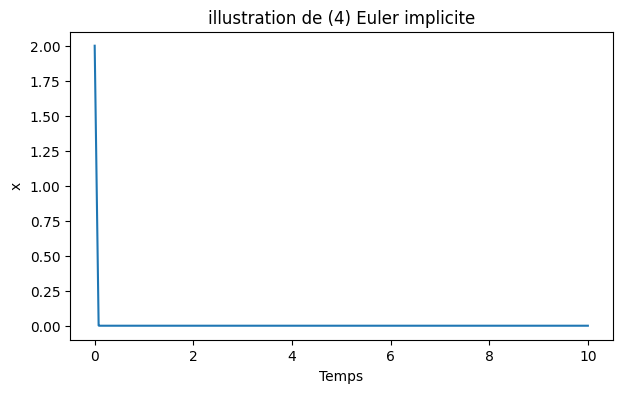

In [40]:
temps_impl, solution_impl = euler_implicit_sliding(25,delta, x0=2, t0=0, tf=10, dt=0.01)
plt.plot(temps_impl,solution_impl)
plt.title('illustration de (4) Euler implicite')
plt.xlabel('Temps')
plt.ylabel('x')
plt.show()

Là, nous n'avons plus de problème de chattering, la courbe est plate une fois à 0. En fait, le schéma implicite anticipe en quelque sorte les sauts qu'on avait avec le schéma explicite et on a donc plus ces sauts car il le met direct à 0. 

**Question 8** Application : donner un exemple physique d'un oscillateur évoluant selon
$$
\begin{array}{rcl}
\dot{x}_1 &=& x_2 \\
\dot{x}_2 &=& -x_1 - k {\rm sign}(x_2)  
\end{array}
$$
et proposer un schéma numérique pour simuler son comportement.

In [41]:
def euler_implicit_friction(x0,t0,tf,dt):
    
    return time, sol
